In [2]:
import numpy as np
from scipy import linalg as la
import matplotlib.pyplot as plt
import os
import pandas as pd
import scipy.signal as sig


In [5]:
#need to design a simple LTI system simulator with gaussian input and outout noise
#we're just doing this for a SISO system


class LTISim(object):
    def __init__(self,A,B,C,Q,R,v1,v2):
        self.A = A
        self.B = B
        self.C = C
        self.var1 = v1
        self.var2 = v2
        self.state = np.zeros(A.shape[0])
        self.output = self.C.dot(self.state)
        self.Q = Q #set this to a parameter
        self.R = R #quadratic cost for input I think we should just make this a fixed 1 too. 
        
    def simulate(self,u):
        states = []
        outputs = []
        
        for i in range(len(u)):
            self.state = self.A.dot(self.state) + self.B.dot(u[i]) + \
            np.random.multivariate_normal(mean = np.zeros(len(self.state)),cov = self.var1*np.eye(len(self.state)))
            
            self.output = self.C.dot(self.state)+ np.random.normal(loc = 0,scale = self.var2)
            
            states.append(self.state)
            outputs.append(self.output)
            
            
        
        return u, np.array(outputs)
    
    def collectData(self,numRuns,runLen,inputNoise):
        
#         assert numRuns >= runLen
        
        outputVec = np.zeros(numRuns)
        inputMatrix = np.zeros((numRuns,runLen))
        for i in range(numRuns):
            self.state = np.zeros(len(self.state))
            self.output = 0
            u = np.random.normal(loc = 0,scale = inputNoise, size = (runLen,))
            inputMatrix[i,:] = u
            u,outputs = self.simulate(u)
            outputVec[i] = outputs[-1]
        return inputMatrix, outputVec
    
    def estimateMarkovParamters(self,inputMatrix,outputVec):
        return np.linalg.pinv(inputMatrix.T.dot(inputMatrix)).dot(inputMatrix.T.dot(outputVec))
    
    def createHankelMatrix(self,markovParameters,size):
        assert 2*size < len(markovParameters)
        markovParameters = np.flip(markovParameters)
        
        hankel = np.zeros((size,size))
        
        for i in range(size):
            for j in range(size):
                hankel[i,j] = markovParameters[i+j]
                
        return hankel
    
    def Hokalman2(self,H,n):
    
        u,s,vh = np.linalg.svd(H)

        smat = np.sqrt(np.diag(s))
        smat = smat[:n,:n]
        D1 = u[:,:n].dot(smat)
        D2 = smat.dot(vh[:n,:])

        Cest = D1[0,:]
        Best = D2[:,0]

        Dminus = D2[:,:D2.shape[1]-1].T
        Dplus = D2[:,1:D2.shape[1]].T

        #then we have A*Dminus = Dplus
        #or in other words Dminus^T A^T = Dplus.T right?
        #so then the least squares solution should be 
        Aest = np.linalg.inv(Dminus.T.dot(Dminus)).dot(Dminus.T.dot(Dplus))
        Aest = Aest.T
        
        return Aest,Best.reshape((len(Best),1)),Cest.reshape(1,len(Cest))
    
    def calculate_estimated_control(self,Aest,Best,Cest):
        #here we need to use ricatti equations and then solve 
        #what happens if the ricatti equation solve throws an error?
        #I suppose that won't happen as long as the eigenvalues of the estimated matrix have magnitude less than 1.
        Q = np.eye(Aest.shape[0])*self.Q
        R = np.array([[1]])*self.R
        
        S = la.solve_discrete_are(Aest, Best, Q, R)
        P = la.solve_discrete_are(Aest.T,Cest.T,Q,R)
        
        L = (Aest.dot(P.dot(Cest.T))).dot(np.linalg.inv(Cest.dot(P.dot(Cest.T)) +np.array([[self.var2]])))
        K = (np.linalg.inv(Best.T.dot(S.dot(Best))+R)).dot(Best.T.dot(S.dot(Aest)))
        
        return L,K

    def determine_closed_loop_stability(self,Aest,Best,Cest,L,K):
        
        #we need to determine the transfer function of P and K and then
        #put them together in a nice way
        Pstatespace = sig.StateSpace(self.A,self.B.reshape(len(self.B),1),self.C.reshape(1,len(self.C)))
        Ptr = sig.TransferFunction(Pstatespace)
        
        Ahat= Aest -Best.dot(K) -(L.dot(Cest)).dot(Aest-Best.dot(K))
        
        Kstatespace = sig.StateSpace(Ahat,L,-K)
        Ktr = sig.TransferFunction(Kstatespace)
        
        a = np.poly1d(Ptr.num)
        b = np.poly1d(Ptr.den)
        c = np.poly1d(Ktr.num)
        d = np.poly1d(Ktr.den)
        
        closedLoopDenom = b*d - a*c
        
        roots = closedLoopDenom.r
        return np.max(np.abs(roots)) 
        
        
        
        
#         sysMat = np.zeros((self.A.shape[0]+Aest.shape[0],self.A.shape[0]+Aest.shape[0]))
        
#         sysMat[:self.A.shape[0],:self.A.shape[0]]= self.A
#         sysMat[:self.A.shape[0],self.A.shape[0]:] = -self.B.reshape(len(self.B),1).dot(K)
#         sysMat[self.A.shape[0]:,:self.A.shape[0]] = L.dot(C.reshape(1,len(C)))
#         sysMat[self.A.shape[0]:,self.A.shape[0]:] = Aest-Best.dot(K)-Cest.dot(Aest)-Cest.dot(Best.dot(K))
        
#         return np.max(np.abs(np.linalg.eigvals(sysMat))) #this is the maximum eigenvalue magnitude
        



In [15]:


A = np.array([[.1,.2],[.15,.16]])
B = np.random.rand(2).T
C = np.random.rand(2)
Q = .1
R = np.array([[1]])
v1 = .05
v2 = .02


sim = LTISim(A,B,C,Q,R,v1,v2)
u = np.random.normal(loc= 0,scale =1,size = (20,))
inputmatrix,outputvec = sim.collectData(numRuns=50,runLen=40,inputNoise=1)

mkvParams = sim.estimateMarkovParamters(inputmatrix,outputvec)
H = sim.createHankelMatrix(mkvParams,18)
Aest,Best,Cest = sim.Hokalman2(H,8)

L,K = sim.calculate_estimated_control(Aest,Best,Cest)

sim.determine_closed_loop_stability(Aest,Best,Cest,L,K)


1.0022777202853783

In [195]:
np.random.rand(2,2)/2

array([[0.03906748, 0.09431074],
       [0.28595016, 0.25416954]])

In [17]:
def create_delay_matrix(dim,delay_param):
    A = np.diag(np.ones(dim-1),k=-1)
    
    A[:2,:2] = np.array([[0.3906748, 0.29431074],[0.28595016, 0.35416954]])
    
    
    A[0,-1] = delay_param
    B = np.zeros(dim)
    C = np.zeros(dim)
    B[0] =1
    C[0] = 1
    return A,B,C

In [108]:
from tqdm import tqdm

xvals = np.linspace(.1,1,20) #spectral radius
prob_of_stability = np.zeros(20)

num_trials = 1000


for j in tqdm(range(len(xvals))):
    v = xvals[j]
    
    for i in range(num_trials):

        A,B,C = create_delay_matrix(4,-.1)
        # A = np.random.rand(20,20)/10
        # B = np.random.rand(20).T
        # C = np.random.rand(20)

        H = orthTransform(4)
        
        d = np.random.rand(4)*v
        d[0] = v

        A = H.dot(np.diag(d).dot(H.T))

        

        Q = np.eye(4)
        R = np.array([[1]])
        v1 = .25
        v2 = .25



        sim = LTISim(A,B,C,Q,R,v1,v2)
        # u = np.random.normal(loc= 0,scale =1,size = (10,))
        inputmatrix,outputvec = sim.collectData(numRuns=25,runLen=20,inputNoise=1)

        mkvParams = sim.estimateMarkovParamters(inputmatrix,outputvec)
        H = sim.createHankelMatrix(mkvParams,9)
        Aest,Best,Cest = sim.Hokalman2(H,3)

        L,K = sim.calculate_estimated_control(Aest,Best,Cest)

        norm = sim.determine_closed_loop_stability(Aest,Best,Cest,L,K)
        
        if norm<1:
            prob_of_stability[j]+=1
            
prob_of_stability/=1000


        


100%|██████████| 20/20 [16:20<00:00, 49.04s/it]


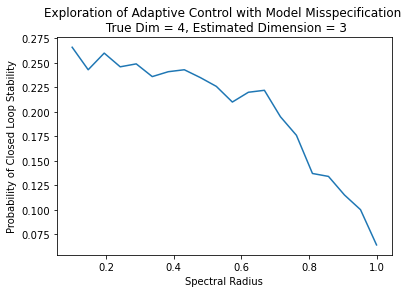

In [109]:
plt.figure()
plt.plot(xvals,prob_of_stability)
plt.xlabel('Spectral Radius')
plt.title('Exploration of Adaptive Control with Model Misspecification \n True Dim = 4, Estimated Dimension = 3')
plt.ylabel('Probability of Closed Loop Stability')
# plt.savefig('CounterexamplePlot.pdf')
plt.show()

In [ ]:
## print(Best)
Best.reshape((2,1))

In [55]:
a = np.array([[.5, 1], [0, -1]])
b = np.array([[1, -1], [2, 1]])
q = np.array([[-2, -4], [-4, 7]])
r = np.array([[9, 3], [3, 1]])
x = la.solve_discrete_are(a, b, q, r)
x


np.max(np.abs(np.linalg.eigvals(a)))

# R = la.solve(r + b.T.dot(x).dot(b), b.T.dot(x).dot(a))
# np.allclose(a.T.dot(x).dot(a) - x - a.T.dot(x).dot(b).dot(R), -q)


1.0

In [15]:
A = np.array([[.1,.52],[.71,.2]])
B = np.array([1,1]).T
C = np.array([[1,0]])

H = np.zeros((30,30))

for i in range(30):
    for j in range(30):
        H[i,j] = C.dot(np.linalg.matrix_power(A,i+j).dot(B))


n = 2

def Hokalman2(H,n):
    
    u,s,vh = np.linalg.svd(H)
    
    smat = np.sqrt(np.diag(s))
    smat = smat[:n,:n]
    D1 = u[:,:n].dot(smat)
    D2 = smat.dot(vh[:n,:])
    
    Cest = D1[0,:]
    Best = D2[:,0]
    
    Dminus = D2[:,:D2.shape[1]-1].T
    Dplus = D2[:,1:D2.shape[1]].T
    
    #then we have A*Dminus = Dplus
    #or in other words Dminus^T A^T = Dplus.T right?
    #so then the least squares solution should be 
    Aest = np.linalg.inv(Dminus.T.dot(Dminus)).dot(Dminus.T.dot(Dplus))
    Aest = Aest.T
    return Aest,Best,Cest

Aest,Best,Cest = Hokalman2(H,n)

print(np.linalg.eigvals(Aest))
print(np.linalg.eigvals(A))

print(A)
print(Aest)


[ 0.75967204 -0.45967204]
[-0.45967204  0.75967204]
[[0.1  0.52]
 [0.71 0.2 ]]
[[ 0.74252928  0.14355853]
 [ 0.14355853 -0.44252928]]


In [132]:

Atest = np.diag(np.ones(10),k=-1)
Atest[:2,:2] = np.random.rand(2,2)/2
Atest[0,10] = -.1


np.max(np.abs(np.linalg.eigvals(Atest)))

print(A[:2,:2])


[[0.75809316 0.61007785]
 [0.44697473 0.86588845]]


In [18]:
def orthTransform(dim=3):
    random_state = np.random
    H = np.eye(dim)
    D = np.ones((dim,))
    for n in range(1, dim):
        x = random_state.normal(size=(dim-n+1,))
        D[n-1] = np.sign(x[0])
        x[0] -= D[n-1]*np.sqrt((x*x).sum())
         # Householder transformation
        Hx = (np.eye(dim-n+1) - 2.*np.outer(x, x)/(x*x).sum())
        mat = np.eye(dim)
        mat[n-1:, n-1:] = Hx
        H = np.dot(H, mat)
         # Fix the last sign such that the determinant is 1
    D[-1] = (-1)**(1-(dim % 2))*D.prod()
    # Equivalent to np.dot(np.diag(D), H) but faster, apparently
    H = (D*H.T).T
    return H

H = orthTransform(10)

mat = H.dot(np.diag(.9*np.exp(-.05*np.arange(10))).dot(H.T))
np.linalg.eigvals(mat)



array([0.9       , 0.85610648, 0.57386534, 0.81435368, 0.77463718,
       0.60328804, 0.63421928, 0.6667364 , 0.7009207 , 0.73685768])

array([[ 1.00000000e+00, -2.27320600e-17, -7.17208583e-18],
       [-2.27320600e-17,  1.00000000e+00, -8.86015291e-17],
       [-7.17208583e-18, -8.86015291e-17,  1.00000000e+00]])

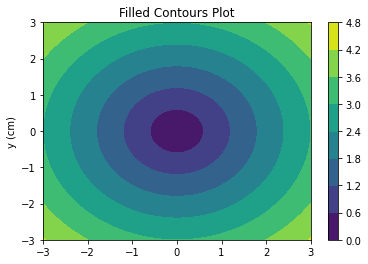

In [110]:
np.arange(10,15,2)

array([10, 12, 14])

In [46]:
#let's plot how this looks with increasing data

from tqdm import tqdm

xvals = np.arange(5,80,2) #data
prob_of_stability = np.zeros(len(xvals))

num_trials = 50

# # H = orthTransform(4)

# # d = np.random.rand(4)*.3
# # d[0] = .3

# # A = H.dot(np.diag(d).dot(H.T))
# # np.random.seed(1)




# Q = 1
# R = 1
# v1 = 0
# v2 = 0


A,B,C = create_delay_matrix(10,-1)

A= np.random.rand(10,10)/5

H = orthTransform(10)
D = .8*np.eye(10)
A = H.dot(D.dot(H.T))

# A= np.random.rand(3,3)/3
# # print(np.max(np.abs(np.linalg)))

# sim = LTISim(A,B,C,Q,R,v1,v2)

# H = orthTransform(3)

# L,K = sim.calculate_estimated_control(H.dot(A.dot(H.T)),H.dot(B.reshape(len(B),1)),(C.reshape(1,len(C))).dot(H.T))

# norm = sim.determine_closed_loop_stability(H.dot(A.dot(H.T)),H.dot(B.reshape(len(B),1)),(C.reshape(1,len(C))).dot(H.T),L,K)
# print(norm)

# L,K = sim.calculate_estimated_control(A,B.reshape(len(B),1),C.reshape(1,len(C)))

# norm = sim.determine_closed_loop_stability(A,B.reshape(len(B),1),C.reshape(1,len(C)),L,K)
# print(norm)

# assert False

print(np.max(np.abs(np.linalg.eigvals(A))))



for j in tqdm(range(len(xvals))):
    
    
    for i in range(num_trials):

        
        # A = np.random.rand(20,20)/10
        # B = np.random.rand(20).T
        # C = np.random.rand(20)

       

        sim = LTISim(A,B,C,Q,R,v1,v2)
        # u = np.random.normal(loc= 0,scale =1,size = (10,))
        inputmatrix,outputvec = sim.collectData(xvals[j],runLen=30,inputNoise=1)

        mkvParams = sim.estimateMarkovParamters(inputmatrix,outputvec)
        H = sim.createHankelMatrix(mkvParams,14)
        Aest,Best,Cest = sim.Hokalman2(H,3)
        

        L,K = sim.calculate_estimated_control(Aest,Best,Cest)

        norm = sim.determine_closed_loop_stability(Aest,Best,Cest,L,K)
        
        if norm<1:
            prob_of_stability[j]+=1
    print(np.linalg.eigvals(Aest))
    print(np.linalg.eigvals(A))
            
prob_of_stability/=50


        

  0%|          | 0/38 [00:00<?, ?it/s]

0.8000000000000005


/Users/daltonjones/opt/anaconda3/lib/python3.8/site-packages/scipy/signal/filter_design.py:1625: BadCoefficients: Badly conditioned filter coefficients (numerator): the results may be meaningless
  warnings.warn("Badly conditioned filter coefficients (numerator): the "
  3%|▎         | 1/38 [00:00<00:33,  1.12it/s]

[-0.07283105+0.93972868j -0.07283105-0.93972868j  0.01917393+0.j        ]
[0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8]


  5%|▌         | 2/38 [00:01<00:34,  1.05it/s]

[ 0.88193226+0.j         -0.62022454+0.72676553j -0.62022454-0.72676553j]
[0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8]


  8%|▊         | 3/38 [00:03<00:37,  1.06s/it]

[0.35456548+0.97596847j 0.35456548-0.97596847j 0.66034642+0.j        ]
[0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8]


 11%|█         | 4/38 [00:04<00:41,  1.22s/it]

[0.65719468+0.j         0.24126438+0.81080362j 0.24126438-0.81080362j]
[0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8]


 13%|█▎        | 5/38 [00:06<00:47,  1.44s/it]

[ 0.98474415+0.j         -0.16254263+0.98832067j -0.16254263-0.98832067j]
[0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8]


 16%|█▌        | 6/38 [00:09<00:56,  1.77s/it]

[ 0.76883795+0.j         -0.50929877+0.69914163j -0.50929877-0.69914163j]
[0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8]


 18%|█▊        | 7/38 [00:12<01:03,  2.06s/it]

[0.81029088+0.j         0.82664913+0.47994043j 0.82664913-0.47994043j]
[0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8]


 21%|██        | 8/38 [00:14<01:08,  2.30s/it]

[0.73262861+0.j         0.31456804+0.82600334j 0.31456804-0.82600334j]
[0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8]


 24%|██▎       | 9/38 [00:18<01:13,  2.55s/it]

[ 0.88886383+0.j         -0.81758589+0.59924232j -0.81758589-0.59924232j]
[0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8]


 26%|██▋       | 10/38 [00:21<01:17,  2.77s/it]

[ 0.78048309+0.j         -0.13855012+0.22383481j -0.13855012-0.22383481j]
[0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8]


 29%|██▉       | 11/38 [00:25<01:23,  3.09s/it]

[0.82165363+0.j         0.03506695+0.92167197j 0.03506695-0.92167197j]
[0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8]


 32%|███▏      | 12/38 [00:29<01:27,  3.36s/it]

[ 0.78645175+0.j        -0.79144206+0.5295445j -0.79144206-0.5295445j]
[0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8]


 34%|███▍      | 13/38 [00:33<01:31,  3.65s/it]

[ 0.79209451+0.j         -0.18872481+0.93891227j -0.18872481-0.93891227j]
[0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8]


 37%|███▋      | 14/38 [00:38<01:34,  3.94s/it]

[0.8      +0.j         0.7562832+0.58572132j 0.7562832-0.58572132j]
[0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8]


 39%|███▉      | 15/38 [00:43<01:38,  4.30s/it]

[ 0.8       +0.j         -0.49835305+0.72778171j -0.49835305-0.72778171j]
[0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8]


 42%|████▏     | 16/38 [00:48<01:41,  4.61s/it]

[ 0.8        -0.06413886 -0.52340341]
[0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8]


 45%|████▍     | 17/38 [00:54<01:43,  4.94s/it]

[ 0.8       +0.j         -0.77109077+0.61951065j -0.77109077-0.61951065j]
[0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8]


 47%|████▋     | 18/38 [01:00<01:45,  5.30s/it]

[0.8       +0.j         0.50337194+0.73555174j 0.50337194-0.73555174j]
[0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8]


 50%|█████     | 19/38 [01:06<01:45,  5.55s/it]

[0.8       +0.j         0.14619615+0.84890281j 0.14619615-0.84890281j]
[0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8]


 53%|█████▎    | 20/38 [01:12<01:44,  5.79s/it]

[0.8      +0.j         0.6894555+0.21233574j 0.6894555-0.21233574j]
[0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8]


 55%|█████▌    | 21/38 [01:19<01:44,  6.12s/it]

[ 0.8       +0.j         -0.32573654+0.61316297j -0.32573654-0.61316297j]
[0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8]


 58%|█████▊    | 22/38 [01:27<01:43,  6.45s/it]

[ 0.8        -0.99565544  0.29091394]
[0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8]


 61%|██████    | 23/38 [01:34<01:42,  6.86s/it]

[0.8      +0.j         0.6446187+0.61440466j 0.6446187-0.61440466j]
[0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8]


 63%|██████▎   | 24/38 [01:43<01:43,  7.43s/it]

[ 0.8         0.70702944 -0.97121505]
[0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8]


 66%|██████▌   | 25/38 [01:53<01:45,  8.11s/it]

[0.8       +0.j         0.19583569+0.73179494j 0.19583569-0.73179494j]
[0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8]


 68%|██████▊   | 26/38 [02:03<01:43,  8.60s/it]

[ 0.8         0.17511245 -1.05651617]
[0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8]


 71%|███████   | 27/38 [02:13<01:38,  9.00s/it]

[ 0.8       +0.j         -0.75351362+0.65074979j -0.75351362-0.65074979j]
[0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8]


 74%|███████▎  | 28/38 [02:23<01:33,  9.36s/it]

[0.8       +0.j         0.09013711+0.76829933j 0.09013711-0.76829933j]
[0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8]


 76%|███████▋  | 29/38 [02:34<01:28,  9.81s/it]

[ 0.8       +0.j         -0.33286617+0.91135679j -0.33286617-0.91135679j]
[0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8]


 79%|███████▉  | 30/38 [02:44<01:20, 10.08s/it]

[ 0.8       +0.j         -0.66493954+0.43162821j -0.66493954-0.43162821j]
[0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8]


 82%|████████▏ | 31/38 [02:55<01:12, 10.33s/it]

[ 0.8       +0.j         -0.68801433+0.49047191j -0.68801433-0.49047191j]
[0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8]


 84%|████████▍ | 32/38 [03:07<01:04, 10.72s/it]

[ 0.8       +0.j         -0.56723837+0.80783042j -0.56723837-0.80783042j]
[0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8]


 87%|████████▋ | 33/38 [03:19<00:55, 11.08s/it]

[0.8       +0.j         0.39724211+0.91159842j 0.39724211-0.91159842j]
[0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8]


 89%|████████▉ | 34/38 [03:31<00:45, 11.31s/it]

[0.8       +0.j         0.13486498+0.74293098j 0.13486498-0.74293098j]
[0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8]


 92%|█████████▏| 35/38 [03:43<00:35, 11.69s/it]

[ 0.8       +0.j         -0.66655717+0.73186234j -0.66655717-0.73186234j]
[0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8]


 95%|█████████▍| 36/38 [03:56<00:23, 11.97s/it]

[ 0.8       +0.j         -0.82250553+0.27529249j -0.82250553-0.27529249j]
[0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8]


 97%|█████████▋| 37/38 [04:09<00:12, 12.32s/it]

[ 0.8       +0.j        -0.56352057+0.2470593j -0.56352057-0.2470593j]
[0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8]


100%|██████████| 38/38 [04:22<00:00,  6.92s/it]

[0.8       +0.j         0.76491297+0.56429803j 0.76491297-0.56429803j]
[0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8]


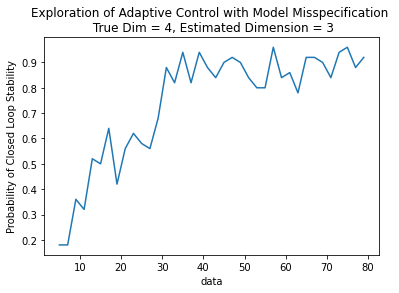

In [47]:
plt.figure()
plt.plot(xvals,prob_of_stability)
plt.xlabel('data')
plt.title('Exploration of Adaptive Control with Model Misspecification \n True Dim = 4, Estimated Dimension = 3')
plt.ylabel('Probability of Closed Loop Stability')
# plt.savefig('CounterexamplePlot.pdf')
plt.show()